In [24]:
# load libraries
from bertopic import BERTopic
from helper_functions import PATHS
from helper_functions import loadJson
from helper_functions import saveJson
from helper_functions import getTopicModelPath
from helper_functions import getCustomLabelPath
from helper_functions import getCharacterTopics
from helper_functions import getSeriesTopics
import pandas as pd
import flatdict
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# load data
'''
    Star Trek The Original Series (TOS) (1966)
    Star Trek The Animated Series (TAS) (1973)
    Star Trek The Next Generation (TNG) (1987)
    Star Trek Deep Space Nine (DS9)     (1993)    
    Star Trek Voyager (VOY)             (1995)
    Star Trek Enterprise (ENT)          (2001)
allseriesline={seriesname:{episode number:{character:alllines}}}
'''
series_order = ['TOS','TAS','TNG','DS9','VOY','ENT']
series_years = [1966, 1973, 1987, 1993, 1995, 2001] #from wikipedia https://en.wikipedia.org/wiki/Star_Trek
show_name = 'STARTREK'
series_lines_dict = loadJson(PATHS['series_lines'])

In [26]:
# functions
def loadTopicModels(series_lines_dict:dict)->dict:
    """Fits a BertTopic model to each series' corpus. The models are each saved for easy retrieval when the code is run again
    The output is a dictionary where each key represents the series name and the content the trained BertTopic model.

    Args:
        series_lines_dict (dict): The loaded all_series_lines.json 

    Returns:
        topic_models: topic_models = {series_name: bert_topic_model}
    """    
    # the assumption is that each series takles different themes and topics, so modelling is done on a series basis.
    topic_models = {}
    for series, series_dict in series_lines_dict.items():
        series_corpus = []
        for _, episode_v in series_dict.items():
            for _, character_line in episode_v.items():
                if len(character_line)>0:
                    series_corpus.extend(character_line)

        topic_model_path = getTopicModelPath(series)
        if os.path.exists(topic_model_path):
            topic_model = BERTopic.load(topic_model_path)
        else:
            topic_model = BERTopic()
            topic_model.fit_transform(series_corpus)
            topic_model.save(topic_model_path)
        topic_models[series] = topic_model

    # get topics for whole show
    show_corpus = []
    for series, series_dict in series_lines_dict.items():
        for _, episode_v in series_dict.items():
            for _, character_line in episode_v.items():
                if len(character_line)>0:
                    show_corpus.extend(character_line)
    
    topic_model_path = getTopicModelPath(show_name)
    if os.path.exists(topic_model_path):
        topic_model = BERTopic.load(topic_model_path)
    else:
        topic_model = BERTopic()
        topic_model.fit_transform(show_corpus)
        topic_model.save(topic_model_path)
    topic_models[show_name] = topic_model

    return topic_models

def analyseCharacterLines(series_lines_dict:dict)->dict:
    """given the all_series_lines data, analyse each character within each series,
    calculate the number of lines they have, words they speak, and episodes the show
    up in. 

    Args:
        series_lines_dict (dict): The loaded all_series_lines.json 

    Returns:
        dict: series_character_lines[series][character] = { 'line_count': .,
                                                            'word_count': .,
                                                            'episode_count': .,
                                                            'lines': [...],}
    """    
    # There are different series, the assumption is that there are different 
    # characters in each series, so it would make sense to analyse characters on
    # a series by series basis
    series_character_lines = {}
    for series, series_dict in series_lines_dict.items():
        series_character_lines[series] = {}
        for _, episode_dict in series_dict.items():
            for character, character_lines in episode_dict.items():
                if character not in series_character_lines[series].keys():
                    series_character_lines[series][character] = {   'line_count': 0,
                                                                    'word_count': 0,
                                                                    'episode_count': 0,
                                                                    'lines': [],}
                n_cw = sum([len(line.split(' ')) for line in character_lines if len(line)>0])
                n_cl = len([line for line in character_lines if len(line)>0])
                series_character_lines[series][character]['line_count']+=n_cl
                series_character_lines[series][character]['word_count']+=n_cw
                series_character_lines[series][character]['episode_count']+=1

                for line in character_lines:
                    if len(line)>0:
                        series_character_lines[series][character]['lines'].extend([line])
    return series_character_lines

def analyseCharacterVerbosity(series_character_lines:dict)->dict:
    """analyse the verbosity of each character in each series. This includes returning 
    those with the most lines (top 5), those with the most spoken words, words per line,
    and main characters that are defined by most episode appearance and word count (top 5). 

    Args:
        series_character_lines (dict): output from analyseCharacterLines function

    Returns:
        dict: series_character_stats_dict[series] = {   'top_5_by_lines': [...],
                                                        'most_verbose_by_word_count': '..',
                                                        'most_verbose_by_line_normalized_word_count': '..',
                                                        'most_episode_and_word_count': [...]}
    """    
    # for each series, who has most lines (top 5), is the most verbose
    series_character_stats_dict = {}
    for series, series_character_stats in series_character_lines.items():
        series_character_stats_df = pd.DataFrame(series_character_stats).T

        consider_index = series_character_stats_df.query('line_count>0').index
        series_character_stats_df['word_per_line'] = np.nan
        series_character_stats_df.loc[consider_index,'word_per_line'] = series_character_stats_df.loc[consider_index, 'word_count']/series_character_stats_df.loc[consider_index, 'line_count']

        top_5_by_lines = series_character_stats_df.sort_values('line_count', ascending=False).iloc[0:5]
        most_verbose_by_word_count = series_character_stats_df.sort_values('word_count', ascending=False).iloc[0]
        most_verbose_by_line_normalized_word_count = series_character_stats_df.sort_values('word_per_line', ascending=False).iloc[0]
        # main characters are assumed to appear the most and have the most to say
        most_episode_and_word_count = series_character_stats_df.sort_values(['episode_count','word_count'], ascending=False).iloc[0:5]
        series_character_stats_dict[series] = { 'top_5_by_lines': list(top_5_by_lines.index),
                                                'most_verbose_by_word_count': most_verbose_by_word_count.name,
                                                'most_verbose_by_line_normalized_word_count': most_verbose_by_line_normalized_word_count.name,
                                                'most_episode_and_word_count': list(most_episode_and_word_count.index)}

    return series_character_stats_dict

def getCustomTopicLabels(topic_models:dict)->dict:
    """the topic name returned by BertTopic is not easy to read, and a manual labelling is required
    this function lets the user decide on what to label each topic given the list of words that represent
    each topic. Once the top 10 topics for each series' labels are entered, the information is saved in a 
    json for future retreival.

    Args:
        topic_models (dict): dict including the trained topic models for each series and entire show

    Returns:
        dict: bespoke labels for each topic for each series 
    """    
    # set custom labels manually
    custom_label_collection = {}
    for series in topic_models.keys() :
        custom_label_path = getCustomLabelPath(series)
        if os.path.exists(custom_label_path):
            custom_labels = loadJson(custom_label_path)
            custom_labels = {int(k): v for k,v in custom_labels.items()}
            custom_label_collection[series] = custom_labels
        else:
            print(topic_models[series].get_topic_info())
            custom_labels = {}
            for i in range(0,10):
                print(topic_models[series].get_topic(i))
                name = input()
                custom_labels[i] = name
            custom_label_collection[series] = custom_labels
            saveJson(custom_labels, custom_label_path)
    return custom_label_collection

def getMainCharacterTopics(series_character_stats_dict:dict, topic_models:dict, series_character_lines:dict, custom_label_collection:dict)->dict:
    """given the main characters, use the topic model for their respective series to predict the topics that they discuss.
    Return the 99th percentile of the topics discussed by each of these characters.

    Args:
        series_character_stats_dict (dict): output from analyseCharacterVerbosity
        topic_models (dict): output from loadTopicModels
        series_character_lines (dict): output from analyseCharacterLines
        custom_label_collection (dict): output from getCustomTopicLabels

    Returns:
        dict: main_character_main_topics[series][character] = [topic_1, ...]
    """    
    # who are the main characters
    # the main characters should be the ones that are in most episodes and have highest word counts
    main_character_main_topics = {}
    for series, character_stats in series_character_stats_dict.items():
        main_characters = character_stats['most_episode_and_word_count']
        main_character_main_topics[series] = {}
        for character in main_characters:
            character_topics_df_path = getCharacterTopics(series, character)
            if os.path.exists(character_topics_df_path):
                character_topics_df = pd.read_csv(character_topics_df_path)
            else:        
                character_topic_prediction = topic_models[series].transform(series_character_lines[series][character]['lines'])
                character_topics_df = pd.DataFrame(character_topic_prediction).T.rename(columns={0:'topic',1:'p'})
                character_topics_df['topic'] = character_topics_df['topic'].astype(int)
                character_topics_df.to_csv(character_topics_df_path, index=False)
            topic_counts = character_topics_df.query("p>0.7").value_counts('topic').reset_index().rename(columns={0:'count'}) # lines that have an assigned topic probability of >0.5 are considered
            
            topic_count_main = np.quantile(topic_counts.query('topic>=0')['count'],0.99) # main topics are in the top 10th percentile of discussed topic by character
            main_discussed_topics = topic_counts.query('topic>=0').query(f"count>={topic_count_main}")

            main_character_main_topics[series][character] = []
            for topic in main_discussed_topics['topic']:
                if topic in custom_label_collection[series].keys():
                    topic_label = custom_label_collection[series][topic]
                else:
                    topic_label = topic_models[series].topic_labels_[topic]
                main_character_main_topics[series][character].append(topic_label)

    return main_character_main_topics

def getTopicsForEachSeriesBasedOnShowTopicModel(series_lines_dict:dict, topic_models:dict)->dict:
    """instead of identifying the topics discussed in each show using their own respective models,
    a model trained on the entire show was used.  

    Args:
        series_lines_dict (dict): The loaded all_series_lines.json
        topic_models (dict): output from loadTopicModels

    Returns:
        dict: series_topics[series] = pd.DataFrame that includes [topic, probability of topic]
    """    
    # tried to see if training model on the entire show and then using it to 
    # predict topic for each series, would result in a more clear identification
    # of topic progression. but it didnt work
    series_topics = {}
    for series, series_dict in series_lines_dict.items():
        series_topic_path = getSeriesTopics(series)
        if os.path.exists(series_topic_path):
            print(f"loading {series} topic")
            series_topics[series] = pd.read_csv(series_topic_path)
            series_topics[series]['topic'] = series_topics[series]['topic'].astype(int)
        else:
            print(f"processing {series} topic")
            series_corpus = []
            for _, episode_v in series_dict.items():
                for _, character_line in episode_v.items():
                    if len(character_line)>0:
                        series_corpus.extend(character_line)
            series_topic = topic_models[show_name].transform(series_corpus)
            series_topics[series] = pd.DataFrame(series_topic).T.rename(columns={0:'topic',1:'p'})
            series_topics[series]['topic'] = series_topics[series]['topic'].astype(int)
            series_topics[series].to_csv(series_topic_path, index=False)
    return series_topics

def getTopicsForEachSeriesBasedOnSeriesTopicModel(topic_models:dict, custom_label_collection:dict)->dict:
    """Indentify topics discussed in each show using their own respective models

    Args:
        topic_models (dict): output from loadTopicModels
        custom_label_collection (dict): output from getCustomTopicLabels

    Returns:
        dict: series_topic_labels[series] = [topic_1,...]
    """    
    series_topic_labels = {}
    for series in series_order:
        series_topic_labels[series] = []
        topic_info_for_series = topic_models[series].get_topic_info().query('Topic>=0')
        main_series_topics = topic_info_for_series.iloc[0:10]
        for topic in main_series_topics['Topic']:
            if topic in custom_label_collection[series].keys():
                topic_label = custom_label_collection[series][topic]
            else:
                topic_label = topic_models[series].topic_labels_[topic]
            series_topic_labels[series].append(topic_label)
    return series_topic_labels

def plotTopicsForEachSeries(series_topic_labels:dict):
    """given the discussed topics for each series, plot a heatmap that visualizes the progression of topics throughout the show, 
    ordered by year of series release

    Args:
        series_topic_labels (dict): output from getTopicsForEachSeriesBasedOnSeriesTopicModel

    Returns:
        fig,ax
    """    
    unique_topics = np.unique([topic for s,s_v in series_topic_labels.items() for topic in s_v ])
    topic_map = pd.DataFrame(columns=series_order, index=unique_topics)
    for series in topic_map.columns:
        topic_map.loc[series_topic_labels[series],series] = 1
    topic_map[topic_map.isna()] = 0
    topic_map = topic_map.astype(float)
    fig, ax = plt.subplots(1,figsize=(15, 5))
    topic_map = topic_map.sort_values(list(topic_map.columns), ascending=False)
    _ = sns.heatmap(    topic_map, ax=ax, center=0,
                        square=True, linewidths=.5,
                        yticklabels=topic_map.index)
    return fig,ax

In [27]:
# analyse character stats for line count, verbosity, derive main characters
series_character_lines = analyseCharacterLines(series_lines_dict)
series_character_stats_dict = analyseCharacterVerbosity(series_character_lines)

Who has the most lines? Who are the top 5?

In [28]:
print("In decreasing order of line count")
for series, series_verbosity in series_character_stats_dict.items():
    print(f"{series}: {series_verbosity['top_5_by_lines']}")

In decreasing order of line count
ENT: ['ARCHER', 'TUCKER', "T'POL", 'REED', 'PHLOX']
DS9: ['SISKO', 'KIRA', 'BASHIR', "O'BRIEN", 'ODO']
TOS: ['KIRK', 'SPOCK', 'MCCOY', 'SCOTT', 'SULU']
TAS: ['KIRK', 'SPOCK', 'MCCOY', 'SCOTT', 'SULU']
TNG: ['PICARD', 'RIKER', 'DATA', 'LAFORGE', 'WORF']
VOY: ['JANEWAY', 'EMH', 'CHAKOTAY', 'PARIS', 'TUVOK']


Who is the most verbose?

In [29]:
print("Most verbose by word count")
for series, series_verbosity in series_character_stats_dict.items():
    print(f"{series}: {series_verbosity['most_verbose_by_word_count']}")

Most verbose by word count
ENT: ARCHER
DS9: SISKO
TOS: KIRK
TAS: KIRK
TNG: PICARD
VOY: JANEWAY


In [30]:
print("Most verbose by words per line")
for series, series_verbosity in series_character_stats_dict.items():
    print(f"{series}: {series_verbosity['most_verbose_by_line_normalized_word_count']}")

Most verbose by words per line
ENT: NEWSREEL
DS9: TAMAR
TOS: GORGON
TAS: MEGAN
TNG: HUMANOID
VOY: HOLO-KES


What are the main topics each main character talks about?

Main characters were defined as those that appearded in the most episodes and had the highest word counts (limited to 5)

In [31]:
for series, series_verbosity in series_character_stats_dict.items():
    print(f"{series}: {series_verbosity['most_episode_and_word_count']}")

ENT: ['ARCHER', 'TUCKER', "T'POL", 'PHLOX', 'REED']
DS9: ['SISKO', 'BASHIR', 'KIRA', 'QUARK', "O'BRIEN"]
TOS: ['SPOCK', 'PIKE', 'VINA', 'ONE', 'MAGISTRATE']
TAS: ['KIRK', 'SPOCK', 'MCCOY', 'SCOTT', 'SULU']
TNG: ['PICARD', 'DATA', 'RIKER', 'LAFORGE', 'CRUSHER']
VOY: ['JANEWAY', 'EMH', 'CHAKOTAY', 'PARIS', 'TUVOK']


How do the topics change throughout the series?

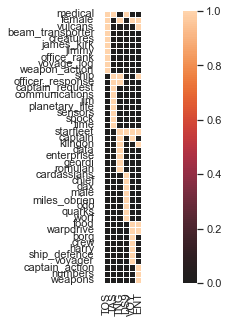

In [32]:
# plot topics for each series
topic_models = loadTopicModels(series_lines_dict)
custom_label_collection = getCustomTopicLabels(topic_models)
series_topic_labels = getTopicsForEachSeriesBasedOnSeriesTopicModel(topic_models, custom_label_collection)
_,_ = plotTopicsForEachSeries(series_topic_labels)

Interesting thing to analyse is does the show get less verbose as time goes by. Shorter attention spans. Or do sentence lengths get shorter.

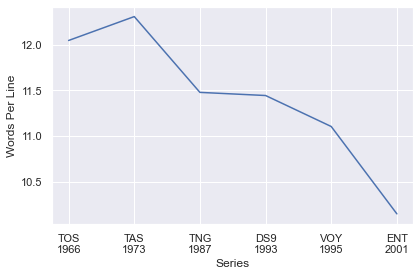

In [38]:
show_characteristics={}
for series, series_dict in series_lines_dict.items():
    n_cw = 0
    n_cl = 0
    for episode, episode_dict in series_dict.items():
        for character, character_lines in episode_dict.items():
            n_cw += sum([len(line.split(' ')) for line in character_lines if len(line)>0])
            n_cl += len([line for line in character_lines if len(line)>0])
    show_characteristics[series] = {'n_episodes': len(series_dict.keys()), 
                                    'n_words': n_cw, 
                                    'n_words_per_line': n_cw/n_cl}
series_characteristics_df = pd.DataFrame(show_characteristics).T.loc[series_order,:]
series_characteristics_df = series_characteristics_df.reset_index().rename(columns={'index':'series'})
fig,ax = plt.subplots(1)
sns.set_theme()
sns.lineplot(data=series_characteristics_df, x='series',y='n_words_per_line', ax=ax)
ax.set_ylabel('words per line'.title())
ax.set_xlabel('series'.title())
ax.set_xticklabels([series_order[i]+f'\n{series_years[i]}' for i in range(0, len(series_order))])
plt.tight_layout()

What I would like to do with more time. In tv, characters tend to evolve to a more extreme version of themselves as writers
concentrate on empahiszing their characteristics. What i would like to do is see if the varaince of topics they discuss is reduced
as they progress through the series. Another thing would be to analyse the sentiment of each character through out the episode. Is 
there a pattern of happy, not happy, then happy that shows an arch of some sort ? 